In [1]:
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from datasets import load_dataset
import pandas as pd
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
import sys

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import subprocess

try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

# Загрузка датасета

In [2]:
dataset = load_dataset("imdb")

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [3]:
train = pd.DataFrame(dataset["train"])
test = pd.DataFrame(dataset["test"])

df = pd.concat([train, test], ignore_index=True)
df

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
49995,Just got around to seeing Monster Man yesterda...,1
49996,I got this as part of a competition prize. I w...,1
49997,I got Monster Man in a box set of three films ...,1
49998,"Five minutes in, i started to feel how naff th...",1


In [4]:
train_text, test_text, train_labels, test_labels= train_test_split(df['text'], df['label'], test_size=0.2, random_state=1024,stratify=df['label'])

print(f"Training samples: {len(train_text)}")
print(f"Testing samples: {len(test_text)}")

Training samples: 40000
Testing samples: 10000


# Создание словаря

In [5]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'http\S+|www.\S+', '', text) # Remove URLs
    text = re.sub(r'\d+', '', text) # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation)) # Remove punctuation
    text = text.strip() # Remove extra whitespace
    text = text.lower() # Lowercase

    #create tokens
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

train_tokens = train_text.apply(clean_text)
test_tokens = test_text.apply(clean_text)

In [6]:
from collections import Counter
all_tokens = [token for tokens in train_tokens for token in tokens] #flatten the list of tokens
token_count = Counter(all_tokens) #count the frequency of each token
MAX_VOCAB_SIZE = 40000 #set the maximum vocab size to the number of tokens
vocab = ['<PAD>','<UNK>'] + [word for word, freq in token_count.most_common(MAX_VOCAB_SIZE - 2)] #create the vocab
wordtoidx = {word: idx for idx, word in enumerate(vocab)} #create the word to index mapping
unk_idx = wordtoidx['<UNK>']
pad_idx = wordtoidx['<PAD>']

In [7]:
def encode_tokens(tokens, wordtoidx,max_len = 200):
    encoded = [wordtoidx.get(token,unk_idx) for token in tokens] 
    if len(encoded) < max_len:
        encoded += [pad_idx] * (max_len - len(encoded))
    else:
        encoded = encoded[:max_len]
    return np.array(encoded)

#encode all the datasets
train_encoded = np.array([encode_tokens(tokens, wordtoidx) for tokens in train_tokens])
test_encoded = np.array([encode_tokens(tokens, wordtoidx) for tokens in test_tokens])

#convert them to numpy array
X_train = np.array(train_encoded.tolist())
X_test = np.array(test_encoded.tolist())

def code(arr):
    result = []
    
    for value in arr:
        if value == 1:
            result.append([0, 1])
        elif value == 0:
            result.append([1, 0])
    
    return result


y_train = np.array(code(train_labels))
y_test = np.array(code(test_labels))

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (40000, 200)
X_test shape: (10000, 200)


S

In [8]:
class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]
    


train_dataset = IMDBDataset(X_train, y_train)
test_dataset = IMDBDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
def train(network,train_loader, test_loader, epochs,loss_fn,optim, plot=True, verbose=True):
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []

    try:
        for epoch in tqdm(range(epochs)):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X,y = X.to(device), y.to(device)
                pred = model(X)
                loss_batch = loss_fn(pred, y)
                losses.append(loss_batch.item())
                optim.zero_grad()
                loss_batch.backward()
                optim.step()
                pred1 = pred.argmax(dim=1).float()
                y1 = y.argmax(dim=1).float()
                accuracies.append((torch.sum(y1 == pred1)/16).cpu())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))

            with torch.no_grad():
                losses = []
                accuracies = []
                for X, y in test_loader:
                    X,y = X.to(device), y.to(device)
                    pred = model(X).squeeze(1)
                    loss_batch = loss_fn(pred, y)
                    losses.append(loss_batch.cpu())
                    pred1 = pred.argmax(dim=1).float()
                    y1 = y.argmax(dim=1).float()
                    accuracies.append((torch.sum(y1 == pred1)/16).cpu())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) Loss: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [14]:
class MyRNNModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyRNNModel, self).__init__()

        self.lin1 = nn.Linear(input_size, hidden_size)
        self.lin2 = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()

        self.hidden_size = hidden_size

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size)
        output = []
        for t in range(seq_len):
            xt = x[:, t, :]
            xt.to(device)

            h_t = self.tanh(self.lin1(xt) + self.lin2(h_t))
            output.append(h_t)
        output = torch.stack(output)

        output = output.transpose(0, 1)
        return output, h_t

class SimpleRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(SimpleRNN, self).__init__() 

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = MyRNNModel(embedding_dim, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim,output_dim),
        )


    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        out = self.fc(output[:,-1,:])
        return out


VOCAB_SIZE = len(vocab)+1
EMBEDDING_DIM = 128
HIDDEN_DIM = 128
OUTPUT_DIM = 2
PAD_IDX = pad_idx

Epoch 29... (Train/Test) Loss: 0.586/0.755	Accuracy: 0.663/0.588

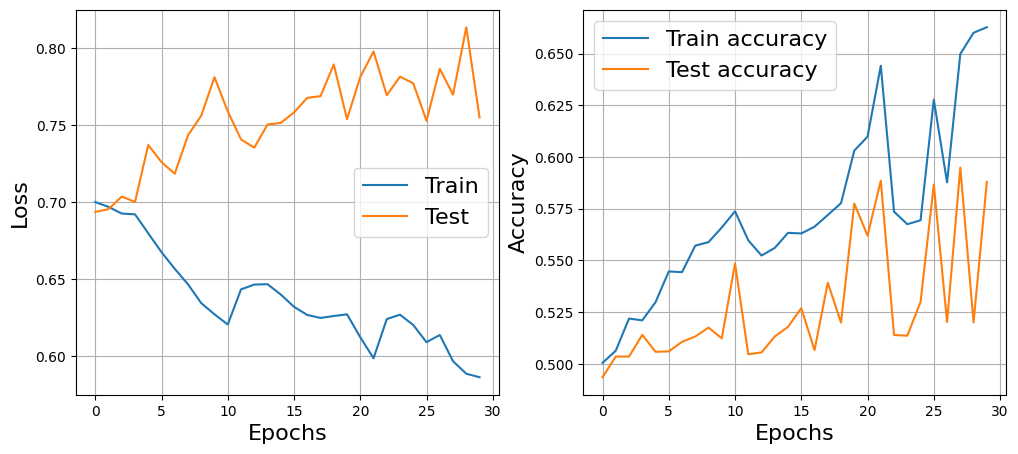

100%|██████████| 30/30 [05:24<00:00, 10.82s/it]


In [108]:
model = SimpleRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = lr)

tr_lenet_sgd, ts_lenet_sgd, tr_ac_lenet_sgd, ts_ac_lenet_sgd = train(
    model,train_loader,test_loader, epochs=30, plot=True, verbose=True, loss_fn=loss, optim=optimizer)

Epoch 19... (Train/Test) Loss: 0.639/0.740	Accuracy: 0.569/0.534

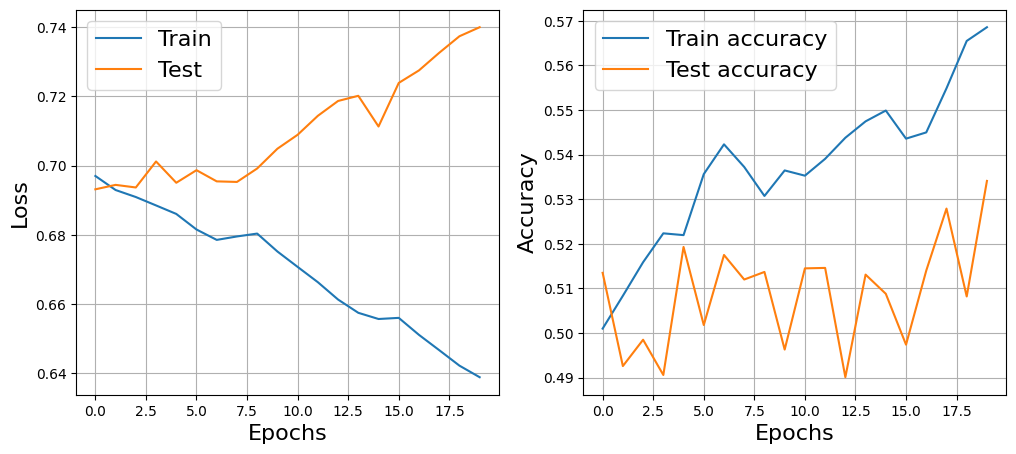

100%|██████████| 20/20 [03:13<00:00,  9.66s/it]


In [110]:
model = SimpleRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.to(device)
lr = 0.01

loss=nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(),lr = lr)

tr_lenet_sgd, ts_lenet_sgd, tr_ac_lenet_sgd, ts_ac_lenet_sgd = train(
    model,train_loader,test_loader, epochs=20, plot=True, verbose=True, loss_fn=loss, optim=optimizer)

Epoch 19... (Train/Test) Loss: 0.685/0.695	Accuracy: 0.519/0.503

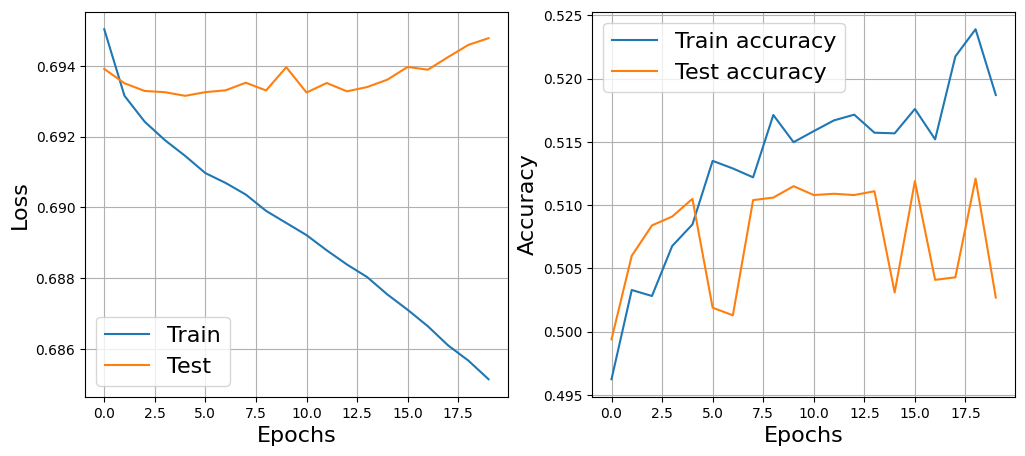

100%|██████████| 20/20 [02:59<00:00,  9.00s/it]


In [122]:
model = SimpleRNN(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.8, nesterov=True)

tr_lenet_sgd, ts_lenet_sgd, tr_ac_lenet_sgd, ts_ac_lenet_sgd = train(
    model,train_loader,test_loader, epochs=20, plot=True, verbose=True, loss_fn=loss, optim=optimizer)

In [41]:
class MyLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(MyLSTMModel, self).__init__()

        self.hidden_size = hidden_size

        self.lin_ix = nn.Linear(input_size, hidden_size)
        self.lin_ih = nn.Linear(hidden_size, hidden_size)
        self.lin_fx = nn.Linear(input_size, hidden_size)
        self.lin_fh = nn.Linear(hidden_size, hidden_size)
        self.lin_gx = nn.Linear(input_size, hidden_size)
        self.lin_gh = nn.Linear(hidden_size, hidden_size)
        self.lin_ox = nn.Linear(input_size, hidden_size)
        self.lin_oh = nn.Linear(hidden_size, hidden_size)

        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size).to(device)
        c_t = torch.zeros(batch_size, self.hidden_size).to(device)
        output = []
        for t in range(seq_len):
            xt = x[:, t, :]
            xt.to(device)

            i_t = self.sigmoid(self.lin_ix(xt) + self.lin_ih(h_t))
            f_t = self.sigmoid(self.lin_fx(xt) + self.lin_fh(h_t))
            g_t = self.tanh(self.lin_gx(xt) + self.lin_gh(h_t))
            o_t = self.sigmoid(self.lin_ox(xt) + self.lin_oh(h_t))

            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * self.tanh(c_t)

            output.append(h_t)
        output = torch.stack(output)

        output = output.transpose(0, 1)
        return output, (h_t, c_t)

class SimpleLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(SimpleLSTM, self).__init__() 

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = MyLSTMModel(embedding_dim, hidden_dim)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim,output_dim),
        )
        self.sigmoid = nn.Sigmoid()


    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        out = self.fc(output[:,-1,:])
        return self.sigmoid(out)

Epoch 29... (Train/Test) Loss: 0.010/0.830	Accuracy: 0.997/0.860

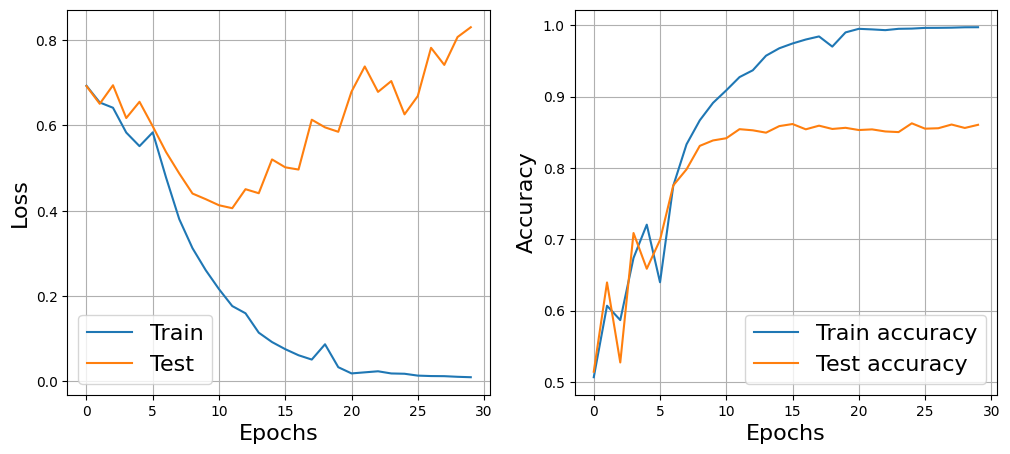

100%|██████████| 30/30 [06:47<00:00, 13.58s/it]


In [127]:
model = SimpleLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = lr)

tr_lenet_sgd, ts_lenet_sgd, tr_ac_lenet_sgd, ts_ac_lenet_sgd = train(
    model,train_loader,test_loader, epochs=30, plot=True, verbose=True, loss_fn=loss, optim=optimizer)

Epoch 9... (Train/Test) Loss: 0.679/0.683	Accuracy: 0.582/0.563

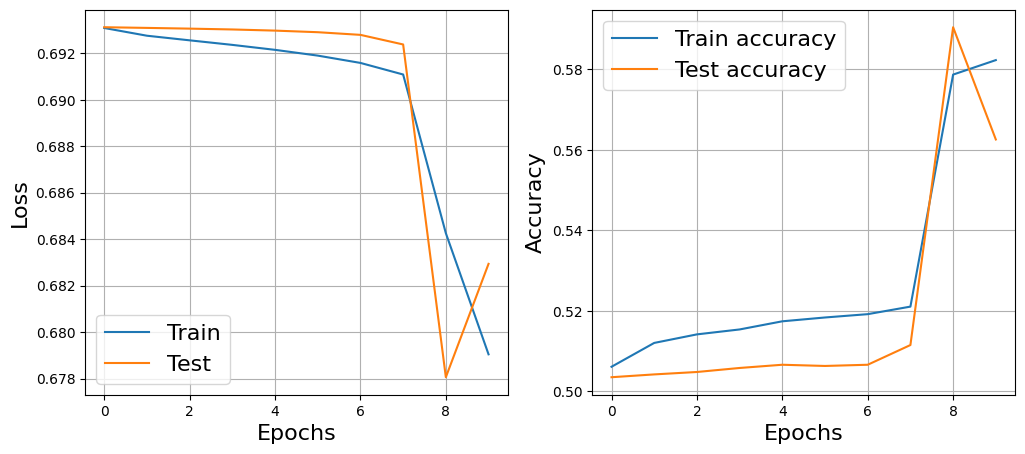

100%|██████████| 10/10 [02:05<00:00, 12.57s/it]


In [45]:
model = SimpleLSTM(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(),lr = lr)

tr_lenet_sgd, ts_lenet_sgd, tr_ac_lenet_sgd, ts_ac_lenet_sgd = train(
    model,train_loader,test_loader, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optimizer)

In [12]:
class MyGRUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUModel, self).__init__()

        self.hidden_size = hidden_size

        self.lin_rx = nn.Linear(input_size, hidden_size)
        self.lin_rh = nn.Linear(hidden_size, hidden_size)
        self.lin_zx = nn.Linear(input_size, hidden_size)
        self.lin_zh = nn.Linear(hidden_size, hidden_size)
        self.lin_nx = nn.Linear(input_size, hidden_size)
        self.lin_nh = nn.Linear(hidden_size, hidden_size)

        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h_t = torch.zeros(batch_size, self.hidden_size)
        output = []
        for t in range(seq_len):
            xt = x[:, t, :]
            xt.to(device)

            r_t = self.sigmoid(self.lin_rx(xt) + self.lin_rh(h_t))
            z_t = self.sigmoid(self.lin_zx(xt) + self.lin_zh(h_t))
            n_t = self.tanh(self.lin_nx(xt) + r_t * self.lin_nh(h_t))
            h_t = (1 - z_t) * n_t + z_t * h_t

            output.append(h_t)
        output = torch.stack(output)

        output = output.transpose(0, 1)
        return output, h_t

class SimpleGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super(SimpleGRU, self).__init__() 

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim,output_dim),
        )


    def forward(self, text):
        embedded = self.embedding(text)
        output, hidden = self.rnn(embedded)
        out = self.fc(output[:,-1,:])
        return out

Epoch 9... (Train/Test) Loss: 0.012/0.720	Accuracy: 0.996/0.867

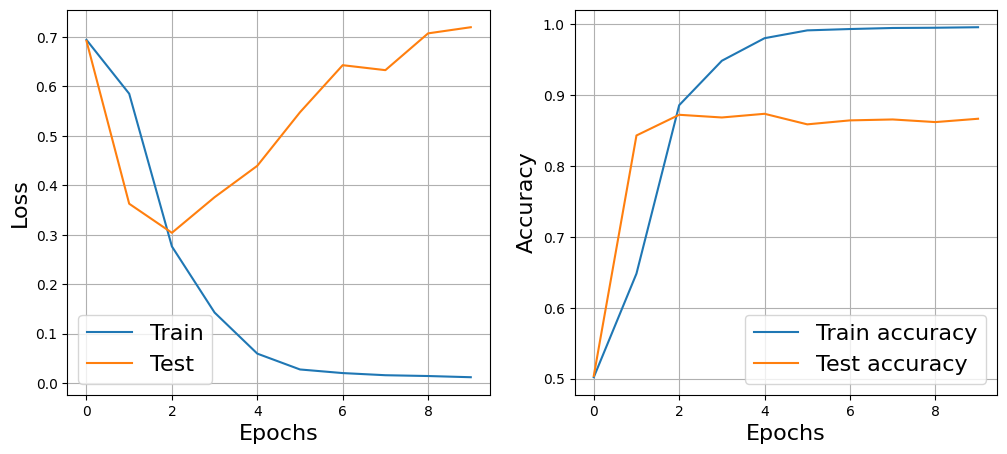

100%|██████████| 10/10 [01:55<00:00, 11.58s/it]


In [130]:
model = SimpleGRU(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.to(device)
lr = 0.001

loss=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr = lr)

tr_lenet_sgd, ts_lenet_sgd, tr_ac_lenet_sgd, ts_ac_lenet_sgd = train(
    model,train_loader,test_loader, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optimizer)

Epoch 9... (Train/Test) Loss: 0.193/0.412	Accuracy: 0.930/0.863

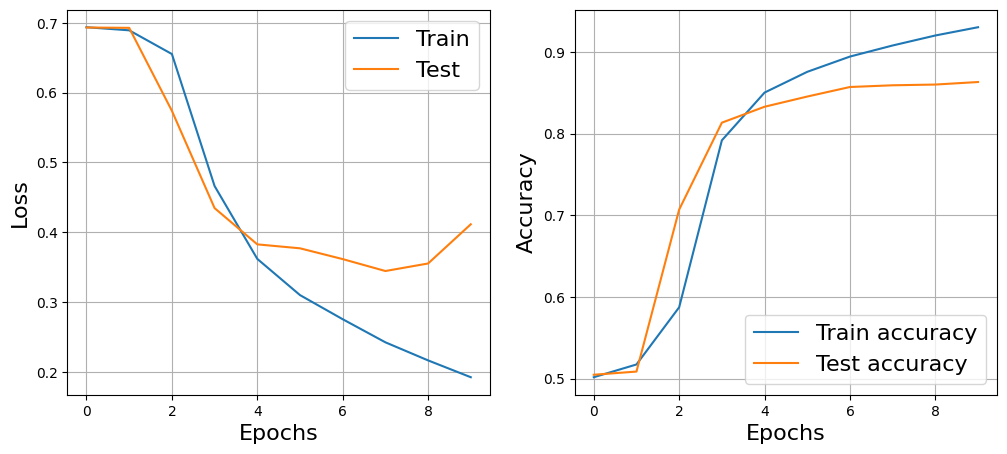

100%|██████████| 10/10 [01:55<00:00, 11.56s/it]


In [19]:
model = SimpleGRU(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM, PAD_IDX)
model.to(device)
lr = 0.0001

loss=nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(),lr = lr)

tr_lenet_sgd, ts_lenet_sgd, tr_ac_lenet_sgd, ts_ac_lenet_sgd = train(
    model,train_loader,test_loader, epochs=10, plot=True, verbose=True, loss_fn=loss, optim=optimizer)